# IMDB movie reviews classification - Part 2

## What about using more powerful stuff this time?

In the previous post about IMDB movie reviews classification, we used a linear model to classify movie reviews. We achieved 87% accuracy on the test set, which is already great. However, we saw that this linear model was based on bags of words which rely on very simplifying assumptions. As a result, and knowing that Neural Networks have set new benchmarks in Natural Language Processing tasks in recent years, is there a way to improve our classification performance? 

The purpose of this post is to take the same data set but to apply a whole different set of Natural Language Processing tools: Neural Networks. 

## 1. Load Data 

As before, the reviews data come from the keras datasets. We will also use keras to build our Neural Networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string

import gensim.downloader as api

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Conv1D, Dense, Dropout, Embedding, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, GRU, LSTM, MaxPooling1D

Using TensorFlow backend.


In [2]:
vocab_size = 3000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)
word_to_index = imdb.get_word_index()

1646592/1641221 [==============================] - 1s 0us/step


## 2. Reformating the reviews

### Tokenizing

As we saw in the previous post, there is not much data preparation to be done here because this Keras package does most of the work for us beforehand. As can be seen below, the tokenizing step has already been done for us by Keras (nice!), which means that words have been converted to numbers. 

In [3]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


If you want to circle back to the actual words of these reviews, they are all stored in the word_to_index dictionary. This is how you can convert the tokenized version of the reviews back to actual text.

In [0]:
word_to_index = dict([(key,(value+3)) for key,value in word_to_index.items()]) 
word_to_index["<PAD>"] = 0
word_to_index["<START>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = dict([(value, key) for (key, value) in word_to_index.items()])

def to_words(review):
  return [index_to_word[i] for i in review]

In [5]:
print('label: %s' % train_labels[0])
print('review: %s' % ' '.join(to_words(train_data[0])))

label: 1
review: <START> this film was just brilliant casting location scenery story direction <UNK> really <UNK> the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> island as myself so i loved the fact there was a real connection with this film the witty <UNK> throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what

### Padding

Don't be upset about all the UNK tags that you can see, this is just because we limited the vocabulary size to 3000 when we loaded the data. UNK basically means that it would have been a rare word or a name (there are lots of actors names in the reviews as you can imagine).

The data exploration part done in the previous post had shown us that the length of the reviews are varying a lot. This is an issue for the algorithms we want to use here, as they need all text inputs to have the same number of words. We can get around this issue thanks to padding. Padding essentially just ensures each list of tokens has the same length by either truncating or adding 0's at the end of the review. Note that 0 corresponds to 'PAD' in the word_to_index dictionary we have defined above!

When using the bag of words in our previous post, we restrained ourselves to the first 500 words. To ensure a fair comparison, let us use padding here with the same cap.

In [0]:
max_len = 500

train_data_padded = pad_sequences(train_data, maxlen=max_len, padding='pre')
test_data_padded = pad_sequences(test_data, maxlen=max_len, padding='pre')

Now we're all set for the modeling part!

## 3. Classification with Dense Neural Networks

When building a Neural Network for Natural Language Processing, it is important to keep in mind that there are two steps:

- First, the text gets converted to Embeddings. In other words, each word gets assigned a vector, and a sentence (in our case, a review) gets represented by a matrix which is the concatenation of all these vectors
- These embeddings are then connected to a Neural Network with hidden layers

Embeddings play a key role in NLP models. There are many differences with the vectorized Bag of Words we saw in the previous post. To keep it short, the main advantage is that it should be able to capture semantics by representing each word in a vector space. However, the main drawback is that they require to learn a lot of parameters and a lot of data to do so. Suppose we want to have an embedding size of 32 and 3,000 words in our vocabulary, this implies we will have to learn 96,000 parameters. This is not an issue per se, as a matter of fact, it is still reasonable compared to other mainstream neural networks. However, it means we need a lot of data to train these embeddings accurately. As a result, there are two ways to go at this stage:

- Either you want to train your own embeddings from scratch...
- Or you use embeddings that have been computed previously on larger datasets. This is called transfer learning, because you transfer parameters from previous machine learning tasks to a new one.

The latter option has grown popular as it usually saves time and allows training on much larger datasets than just our reviews, which might yield better results. But let us check for ourselves if it really adds anything here...



### Learning Embeddings from scratch



Let us start with the first option, which is basically having the embeddings learned by the neural network before the dense layers. 

First, we set our embeddings to have a size of 50, which means that each word will be represented by a vector of 50 values. We will run our network on 10 epochs, which means that each review will be passed to the model 10 times during the training phase. We set the batch size to be 128, which means the parameters will be updated for batches of 128 reviews at a time in each epoch.

In [0]:
embedding_size = 50
epochs = 10
batch_size = 128

Let us go through the model below step by step. 

- First, we define the Embedding layer. It has to learn $50 \times 3000 = 150000 $ parameters, because each word gets represented by a vector of 50 elements. After a review passes through this layer, it is a matrix of size (500,50) because it concatenates the embeddings of each word of the review (we set the length of each review to be 500 words when we padded the reviews!)
- We then compute the average of this matrix on each of the 50 embedding dimensions. This step aims to reduce the dimensionality of our reviews by aggregating information. In the deep learning jargon, this is called "Pooling". At this stage, the review is now summarized in a vector of 50 values.
- These values are connected to 64 hidden nodes with linear transformations on each edge of this dense graph ($y = w.x+b$). As a result, there are $64 \times 50 = 3200$ weights to learn and 64 biases. Hence, there are 3264 parameters to be trained at this stage
- Each of the 64 nodes get applied a non-linear function, relu
- We then randomly discard 50% of these nodes, which is called "Dropout". Dropout is a highly efficient step to avoid overfitting.
- Finally, we connect our remaining nodes to the output node, with the same linear transformations as before. So this time, there will be $1\times64 + 1 = 65$ parameters to train.
- Finally, our output gets tranformed to a probability value thanks to the sigmoid function. This probability will represent the probability of being a positive value (the probability of being a negative review will simply be 1 - that)

In [8]:
model_base = Sequential()
model_base.add(Embedding(vocab_size, embedding_size, input_shape=(max_len,)))
model_base.add(GlobalAveragePooling1D())
model_base.add(Dense(64, activation='relu'))
model_base.add(Dropout(rate = 0.5))
model_base.add(Dense(1, activation='sigmoid'))
model_base.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           150000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3264      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 153,329
Trainable params: 153,329
Non-trainable params: 0
_______________

This sums up to 153,329 parameters to train. As you can see, the majority of them come from the embedding step... Let us see how this model performs now!

In [9]:
history = model_base.fit(train_data_padded, train_labels, epochs=epochs, batch_size = batch_size, validation_split = 0.25)

Instructions for updating:
Use tf.cast instead.
Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 4s 204us/step - loss: 0.6791 - acc: 0.5996 - val_loss: 0.6292 - val_acc: 0.7475
Epoch 2/10
18750/18750 [==============================] - 1s 64us/step - loss: 0.5124 - acc: 0.7928 - val_loss: 0.3978 - val_acc: 0.8584
Epoch 3/10
18750/18750 [==============================] - 1s 66us/step - loss: 0.3519 - acc: 0.8644 - val_loss: 0.3286 - val_acc: 0.8718
Epoch 4/10
18750/18750 [==============================] - 1s 66us/step - loss: 0.3024 - acc: 0.8817 - val_loss: 0.3079 - val_acc: 0.8776
Epoch 5/10
18750/18750 [==============================] - 1s 66us/step - loss: 0.2744 - acc: 0.8942 - val_loss: 0.3000 - val_acc: 0.8798
Epoch 6/10
18750/18750 [==============================] - 1s 66us/step - loss: 0.2543 - acc: 0.9010 - val_loss: 0.2937 - val_acc: 0.8821
Epoch 7/10
18750/18750 [==============================] - 1s 65us/step - loss: 0

Text(0.5, 1.0, 'Accuracy and loss on the training and validation set')

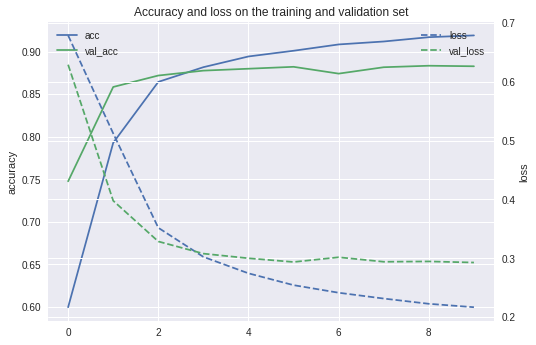

In [10]:
df = pd.DataFrame(history.history)
df[['acc', 'val_acc']].plot()
plt.ylabel("accuracy")
ax = plt.twinx()
df[['loss', 'val_loss']].plot(linestyle='--', ax=ax)
ax.legend(loc = 1)
plt.ylabel("loss")
plt.title("Accuracy and loss on the training and validation set")

We achieve around 88% accuracy on the validation score with this method. Neat isn't it? We already outperformed the linear model from the previous step a bit!

Yes, but does this model work any better than our previous linear model when it comes to retrieving semantics? Let us have a look at this example we discussed before:

In [0]:
reviews = ["i loved this movie it was amazing",
           "this movie was not good at all"]

In [0]:
reviews_data = pad_sequences(np.array([[word_to_index[word] for word in (["<START>"])+review.split()] for review in reviews]), maxlen=max_len, padding='pre')

In [13]:
model_base.predict(reviews_data)

array([[0.862064 ],
       [0.5605663]], dtype=float32)

Our classifier still does not manage to classify the second review correctly... and this makes sense, because using embeddings does not mean we are looking at their associations yet!

### Using pre-trained Embeddings

As stated above, another option is to use embeddings that would be computed before feeding the reviews to our neural network. A popular option is to use the GloVe embeddings (<a href = "https://nlp.stanford.edu/projects/glove/">Global Vector for Word Representation</a>), which have been trained on Wikipedia articles (among others). 

It's quite easy to do, especially thanks to the gensim library that also allows to do a lot of cool stuff as we'll see below.

In [14]:
word_vectors = api.load("glove-wiki-gigaword-50") 

[==================================================] 100.0% 66.0/66.0MB downloaded


Let us digress here for a second and have a look at all the fancy things one can do with gensim. For instance, you can check what words are most similar in the way they are used. This works by simply computing the cosine between each embedding and keeping the maximum value. You can see this as a dot product that evaluates how similar two vectors are..

In [15]:
word_vectors.most_similar("movie", topn = 5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('movies', 0.9322481155395508),
 ('film', 0.9310100078582764),
 ('films', 0.8937394022941589),
 ('comedy', 0.8902586102485657),
 ('hollywood', 0.8718215823173523)]

For instance, the word closest to "movie" is "movies" (the numeric value is the cosine score), followed by "film" and "films". This highlights the power of embeddings. Compare this to the Bag of Words methodology we saw previously, where "film" and "movie" would be treated as two different words. Here, given that their embeddings are similar, they will be treated in a similar way too. This makes a lot of sense!

Some more playing around with gensim. For instance, suppose I write the following review: "I loved this movie because it has great actors and a great castle" because I did a typo and wrote castle instead of cast (or say my automatic correcter did that...). Can embeddings help us to see there is something wrong?

In [16]:
word_vectors.doesnt_match("i loved this movie because it has great actors and a great castle".split())

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'castle'

Yes it can! It correctly identified "castle" as being the outlier here. How did it do that? Simply by computing the average embedding of my review and by identifying that "castle" had the smallest cosine score (smallest similiarity) with this average. Nice!

Going a little further, there is another gensim feature that people love to play with... it's the famous "what word c is to word d what word a is to word b" question! For instance, Moscow is to Russia what Paris is to France. Let us try this out with the following example: suppose we are interested to know what the equivalent of man-actor relationship is for a woman...

In [17]:
word_vectors.most_similar_cosmul(positive = ['actor','woman'], negative=['man'], topn = 1)

[('actress', 1.00295889377594)]

Not too surprizingly, it is... "actress"! All it does backstage is translating the operation actor - man + woman in terms of embeddings, and then search for the closest word with the cosine score. Fancy!

Hopefully, this has demonstrated that embeddings open the door to semantics in Natural Language Processing. On another note, this raises questions like "can semantics be captured by vectors?" or "is language a vector space?", which are fascinating questions if you want to think about it.

But enough of playing with these embeddings. Let us see if they are actually useful for our model. 

First, we need to build the embedding matrix with all the GloVe embeddings. The size of the matrix is (500,50) as before.

In [0]:
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in word_to_index.items():
    if word in word_vectors.vocab and i < vocab_size:
        embedding_matrix[i] = word_vectors[word]

We only need to change the first line of code in the model we introduced previously by specifying the weights in our Embedding layer and then by specifying that these weights are not trainable.

In [19]:
model_with_embeddings = Sequential()
model_with_embeddings.add(Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable = False, input_shape=(max_len,)))
model_with_embeddings.add(GlobalAveragePooling1D())
model_with_embeddings.add(Dense(64, activation='relu'))
model_with_embeddings.add(Dropout(rate = 0.5))
model_with_embeddings.add(Dense(1, activation='sigmoid'))
model_with_embeddings.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_with_embeddings.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 50)           150000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3264      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 153,329
Trainable params: 3,329
Non-trainable params: 150,000
_________________________________________________________________


As you can see in this summary, we still have 153,329 parameters as before. Only, this time, the 150,000 embedding parameters are "not trainable", meaning they will not be changed during the training phase. As a result, we are left with only 3,329 parameters to train.

In [20]:
history = model_with_embeddings.fit(train_data_padded, train_labels, epochs=epochs, batch_size = 128, validation_split = 0.25)

Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 1s 51us/step - loss: 0.6835 - acc: 0.5665 - val_loss: 0.6654 - val_acc: 0.6448
Epoch 2/10
18750/18750 [==============================] - 1s 37us/step - loss: 0.6588 - acc: 0.6301 - val_loss: 0.6391 - val_acc: 0.6710
Epoch 3/10
18750/18750 [==============================] - 1s 37us/step - loss: 0.6377 - acc: 0.6595 - val_loss: 0.6167 - val_acc: 0.6898
Epoch 4/10
18750/18750 [==============================] - 1s 37us/step - loss: 0.6190 - acc: 0.6786 - val_loss: 0.5996 - val_acc: 0.7013
Epoch 5/10
18750/18750 [==============================] - 1s 38us/step - loss: 0.6027 - acc: 0.6951 - val_loss: 0.5835 - val_acc: 0.7168
Epoch 6/10
18750/18750 [==============================] - 1s 37us/step - loss: 0.5891 - acc: 0.7047 - val_loss: 0.5714 - val_acc: 0.7266
Epoch 7/10
18750/18750 [==============================] - 1s 36us/step - loss: 0.5773 - acc: 0.7143 - val_loss: 0.5618 - val_acc:

How disappointing! Yes, it does speed up the learning process a little bit, but using these pre-trained embeddings considerably lowers our accuracy. Why is that, although we had seen that these embeddings are able to capture movie semantics quite well while we played around with gensim features?

There might be several reasons to that, but an obvious one is that these embeddings were not computed for our classification problem specifically. They aim to be general word representations and hence might be too general here. Also, the corpus used for the training of the GloVe embeddings might not be that well suited for our task. Wikipedia articles, for instance, do not convey much sentiment or opinion. Hence, these embeddings might be less suited to run sentiment analysis.

On the other hand, the embeddings we computed from scratch were designed so that the loss of our classifier would be minimized. They indeed enable us to achieve best performance and thus we should be considering this option.

## 4. Classification with Convolutional Neural Networks

In the model we built above, we used a Global Average Pooling layer right after the Embedding layer. This means we averaged all 500 embeddings of the reviews along each of the 50 embedding dimensions. This is a necessary step because else we would have to connect these $50 \times 500 = 25,000$ values to the hidden layer, which would result in an explosion of the number of weights to learn and to overfitting. By averaging along each of the dimensions, we aggregate the information into only 50 values, which is much more reasonable.

However, this is something that can raise concern. For instance, many reviews have less than 500 words and contain many padding embeddings. By computing the average like we did before, we allow these padding embeddings to significantly impact our the model prediction, which should not be the case. Another concern is that we still do not take advantage of words associations like negations. In a review such as "I did not like it", the embeddings of each of these 5 words will be averaged and then passed through the hidden layers, but at no point will the "not" + "like" combination be explicitely evaluated.

These problems can be compared to Computer Vision problems. Knowing that there are yellow pixels on the top right corner and blue pixels on the bottom left corner does not help much to analyze the content of the image. One needs to analyze how these pixels are located relatively to each other to gain knowledge from the image. This analogy naturally lead us to consider Convolutional Neural Networks.

Essentially, the Convolutional Neural Network will have the same architecture than the previous models with an Embedding layer at the begginning and Hidden Layers at the end. What changes is the addition of the Convolution filtering inbetween, as you can tell from the model summary below. Let us walk through the architecture of this model as before:

- First we have the Embedding layer that works the same way as before. After this step, our review is a matrix of size (500,50)

- We then add a Convolution layer. Basically, it is a set of weights that computes a rolling weighted average as it scans the matrix along 5 words at a time (this is the kernel_size argument). Naturally, given that each word is represented by a vector of size 50, our convolutional filter scans 250 values at the time. Thus, a filter is composed of 250 weights and 1 bias (251 parameters). Since the filter scans 5 words at a time, it will return a vector of 500-5+1=496 values. This gets repeated for each of the 256 filters. As a result, our output is a matrix of size (496,256), and this layer requires $256 \times (5\times50 + 1) = 64,256$ parameters. Once the filter is applied, we also apply non-linearity through the relu function.

- As a general rule, a Convolutional layer is followed by a pooling layer to reduce dimensionality. Here, we apply a 1-dimensional MaxPooling with a pool size of 4, which means we are splitting each row of the matrix obtained at the previous step in sets of 4 values and keeping only the maximum. This reduces our matrix from size (496,256) to size (124,256). 

- Before the next Convolutional layer, we add another Dropout layer, which randomly discards 50% of the values of the matrix to avoid overfitting

- We repeat the same Convolutional layer as before. This step requires training much more parameters than the first layer, because the input is bigger this time. The number of parameters can be calculated the same way as before by replacing the original embedding dimensionality (50) by the number of filters in the previous step (256): $256 \times (5 \times 256 + 1) = 327,936$. Following the same reasoning as before, the output of this layer will be of size (120,256).

- Again, this layer is followed by a MaxPooling layer that reduces the size of the matrix to (30,256).

- Eventually, we flatten this matrix to a vector of size $30\times256 = 7,680$.

- We apply another Dropout layer to randomly discard 50% of these values.

- This vector is fully connected to a hidden layer of size 128. This results in $7,680\times 128 + 128 = 983,168$ parameters to train. We then apply the activation function relu.

- Finally, these 128 nodes are fully connected to the output layer through the final $128+1=129$ parameters. This output gets converted to the probability of belonging to class 1 with the sigmoid function.

In [21]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, embedding_size, input_shape=(max_len,)))
model_cnn.add(Conv1D(filters = 256, kernel_size = 5, activation='relu'))
model_cnn.add(MaxPooling1D(4))
model_cnn.add(Dropout(rate = 0.5))
model_cnn.add(Conv1D(filters = 256, kernel_size = 5, activation='relu'))
model_cnn.add(MaxPooling1D(4))
model_cnn.add(Flatten())
model_cnn.add(Dropout(rate = 0.5))
model_cnn.add(Dense(128, activation = 'relu'))
model_cnn.add(Dropout(rate = 0.5))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 50)           150000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 256)          64256     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 124, 256)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 124, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 256)          327936    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
__________

We only use 3 epochs here for training, as our CNN does not require more to train all these weights, it would overfit if we were prolonging the training further.

In [22]:
history = model_cnn.fit(train_data_padded, train_labels, epochs=3, batch_size = batch_size, validation_split=0.25)

Train on 18750 samples, validate on 6250 samples
Epoch 1/3
18750/18750 [==============================] - 11s 598us/step - loss: 0.6821 - acc: 0.5323 - val_loss: 0.4913 - val_acc: 0.7530
Epoch 2/3
18750/18750 [==============================] - 8s 453us/step - loss: 0.3467 - acc: 0.8512 - val_loss: 0.2824 - val_acc: 0.8808
Epoch 3/3
18750/18750 [==============================] - 8s 453us/step - loss: 0.2434 - acc: 0.9042 - val_loss: 0.2657 - val_acc: 0.8906


This plot below shows how accuracy improves (and loss decreases) as epochs are being added during the training phase.

Text(0.5, 1.0, 'Accuracy and loss on the training and validation set')

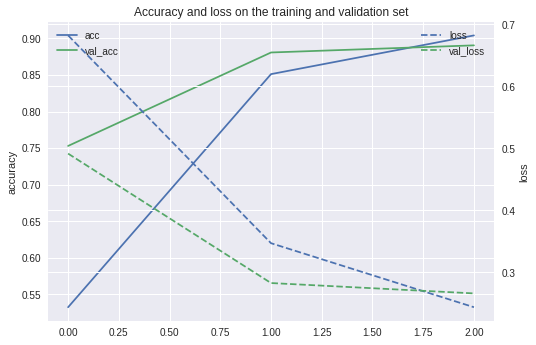

In [23]:
df = pd.DataFrame(history.history)
df[['acc', 'val_acc']].plot()
plt.ylabel("accuracy")
ax = plt.twinx()
df[['loss', 'val_loss']].plot(linestyle='--', ax=ax)
ax.legend(loc = 1)
plt.ylabel("loss")
plt.title("Accuracy and loss on the training and validation set")

We have again improved the accuracy of our classifier, as this CNN achieves around 89% accuracy on the validation set. This is slightly better than the Dense Neural Network we had presented in the start of this post. But beyond the purely statistical advantage, it also gets obvious that the CNN is finally able to do what all the previous models we have presented in so far failed to achieve: extracting semantical information through syntax. Remember our two examples:

In [0]:
reviews = ["i loved this movie it was amazing",
           "this movie was not good at all"]

In [25]:
model_cnn.predict(reviews_data)

array([[0.9085586 ],
       [0.39161095]], dtype=float32)

As you can see below, the CNN successfully classifies both reviews, the first as positive, the second as negative, because it is able to see that "good" is preceded by "not". This is a key advantage of the CNN applied to Natural Language Processing. This qualitative advantage, along with the improved accuracy of the predictions, lead us to select it as our best model to classify movie reviews.

## 5. Model evaluation

Now that we have selected the above CNN-based model as our best model, we need to evaluate it on the test set to get a realistic idea of how well it would work on a totally new set of reviews.

In [31]:
test_accuracy = model_cnn.evaluate(test_data_padded, test_labels)[1]
print("Our CNN achieves a %.2f accuracy on the test set" %test_accuracy)

25000/25000 [==============================] - 5s 215us/step
Our CNN achieves a 0.88 accuracy on the test set


Before wrapping it up, let us have a look at how the model performs on the same two Hitchcock reviews we tried out with the linear model before. Both of them are very positive reviews, so we expect the prediction to be positive too:

a) A review of Notorious (Alfred Hitchcock, 1946) by From Frank Cottrell Boyce, The Guardian 2012 (<a href = "https://www.theguardian.com/film/2012/jun/17/my-favourite-hitchcock-film-notorious-frank-cottrell-boyce">full review here</a>)

"Notorious is perfect. Everyone knows that. It's a testament to Ben Hecht's complex, headlong script that so many people have tried to rip it off and a testament to Hitchcock's genius that no one has ever succeeded. Take a look at the gabby, inconsequential, forgotten Mission Impossible: II and you'll see what I mean. The more obvious glories of Notorious include a revelatory performance from Cary Grant as the morally exhausted American agent Devlin, a terrifying Nazi-mother super-villain played by Leopoldine Konstantin and cinema's most cunningly prolonged kiss."

b) A review of Vertigo (Alfred Hitchcock, 1958) by Peter Bradshaw, The Guardian 2018 (<a href = "https://www.theguardian.com/film/2018/jul/12/vertigo-review-alfred-hitchcock-james-stewart-kim-novak">full review here</a>)

"When I watched this again, I felt more strongly than ever that Hitchcock’s decision to give us a story in which the Clouzot-esque twist is given away well before the end is no misjudgment. It is a brilliant way of putting us inside Judy’s tormented, guilty soul, and of avoiding, just for a while, that male gaze. I also realised what it is Vertigo has been subtly reminding me of for many years: Graham Greene’s The End of the Affair. A treat to see this back on the big screen."

In [0]:
notorious_review = "Notorious is perfect. Everyone knows that. It's a testament to Ben Hecht's complex, headlong script that so many people have tried to rip it off and a testament to Hitchcock's genius that no one has ever succeeded. Take a look at the gabby, inconsequential, forgotten Mission Impossible: II and you'll see what I mean. The more obvious glories of Notorious include a revelatory performance from Cary Grant as the morally exhausted American agent Devlin, a terrifying Nazi-mother super-villain played by Leopoldine Konstantin and cinema's most cunningly prolonged kiss."
vertigo_review = "When I watched this again, I felt more strongly than ever that Hitchcock’s decision to give us a story in which the Clouzot-esque twist is given away well before the end is no misjudgment. It is a brilliant way of putting us inside Judy’s tormented, guilty soul, and of avoiding, just for a while, that male gaze. I also realised what it is Vertigo has been subtly reminding me of for many years: Graham Greene’s The End of the Affair. A treat to see this back on the big screen."

First, we need to format these reviews tokenize them as above. Then, they can be evaluated by the CNN.

In [0]:
hitchcock_reviews = [notorious_review, vertigo_review]
hitchcock_reviews = [''.join(ch for ch in review.lower() if ch not in string.punctuation) for review in hitchcock_reviews]

In [0]:
hitchcock_reviews_transformed = pad_sequences(np.array([[word_to_index[word] for word in (["<START>"])+review.split() if word in word_to_index] for review in hitchcock_reviews]), maxlen=max_len, padding='pre')

In [29]:
model_cnn.predict(hitchcock_reviews_transformed)

array([[0.9547065 ],
       [0.93409747]], dtype=float32)

Both reviews got labeled as positive by our CNN with a very high probability (95% for Notorious and 93% for Vertigo). You can note that these probabilities are higher than those achieved by the linear model in the previous post (71% for Notorious and 92% for Vertigo).

## 6. Conclusion

In this post, we achieved an accuracy of 88% for movie reviews classification using Convolutional Neural Networks (CNN). The use of Convolutional Neural Networks enables to increase the accuracy of movie reviews classification through a transformation from words to embeddings and through a scanning of these embeddings. Thus, the sequential nature of sentences is preserved, which was one of the main drawbacks of the Bag-of-words approach we analyzed in the previous post.

CNN's also have the advantage that they can be trained quite quickly for such tasks. This advantage becomes very relevant when compared to other popular models for Natural Language Processing like RNN's.